<a href="https://colab.research.google.com/github/crispitagorico/Neural-SPDEs/blob/main/Parabolic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone "https://github.com/crispitagorico/Neural-SPDEs.git"

In [ ]:
!git clone "https://github.com/andrisger/Feature-Engineering-with-Regularity-Structures.git"

In [ ]:
!pip install torchcde

In [1]:
import matplotlib.pyplot as plt
import scipy.io
from tqdm.notebook import tqdm
from importlib import reload

In [2]:
%run Feature-Engineering-with-Regularity-Structures/Classes/SPDEs.ipynb
%run Feature-Engineering-with-Regularity-Structures/Classes/Noise.ipynb

# Generate dataset

**Fixed initial condition settings**

In [3]:
dx, dt = 0.01, 0.001 #space-time increments 
k = 2000
# k = 10000 # Number of realizations
# bsize = 100
a, b, s, t = 0, 1, 0, 1 # space-time boundaries

In [4]:
ic = lambda x: x*(1-x) # initial condition
mu = lambda x: 3*x-x**3 # drift
# sigma1 = lambda x: x # multiplicative diffusive term
sigma2 = lambda x: 1 # additive diffusive term

**Generate small dataset with low resolution in space and time**

In [5]:
X, T = Noise().partition(a,b,dx), Noise().partition(s,t,dt) # space grid O_X and time grid O_T
W = Noise().WN_space_time_many(s, t, dt, a, b, dx, k) # Create realizations of space time white noise
Soln_mult = SPDE(BC = 'P', IC = ic, mu = mu, sigma = sigma2).Parabolic(W, T, X)

**Generate large dataset with highest resolution in space and time**

In [ ]:
# for i in tqdm(range(k//bsize)):
#   X, T = Noise().partition(a,b,dx), Noise().partition(s,t,dt) # space grid O_X and time grid O_T
#   W = Noise().WN_space_time_many(s, t, dt, a, b, dx, bsize) # Create realizations of space time white noise
#   # solutions to the multiplicative equation 
#   Soln_mult = SPDE(BC = 'P', IC = ic, mu = mu, sigma = sigma2).Parabolic(W, T, X)
#   scipy.io.savemat('../drive/MyDrive/Phi41_xsi/{}.mat'.format(i), mdict={'X':X, 'T':T, 'W': W.transpose(0,2,1), 'sol': Soln_mult.transpose(0,2,1)})
#   scipy.io.savemat('../drive/MyDrive/Phi41_xsi/small_{}.mat'.format(i), mdict={'X':X, 'T':T,'W': W.transpose(0,2,1)[:,::4,::4], 'sol': Soln_mult.transpose(0,2,1)[:,::4,::4]})

# Model fitting

In [6]:
%cd Neural-SPDEs/

/content/Neural-SPDEs


In [8]:
import torch
import torch.optim as optim
import numpy as np

from utilities import MatReader, LpLoss, count_params
from neuralSPDE_1D import NeuralFixedPoint


torch.manual_seed(0)
import warnings
warnings.filterwarnings('ignore')

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [58]:
xi = torch.from_numpy(W.astype(np.float32)).permute(0,2,1)
data = torch.from_numpy(Soln_mult.astype(np.float32)).permute(0,2,1)

In [59]:
ntrain = 800
ntest = 200

batch_size = 20
epochs = 5000
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5
step = 1
T = 50
sub_t = 1

u0_train = data[:ntrain,:-1,0][:,None,...]
u_train = data[:ntrain,:-1,1:T:sub_t]
xi_train = xi[:ntrain, :-1,1:T:sub_t][:,None,...]
# xi_train = torch.diff(xi[:ntrain, :-1,:T:sub_t],dim=-1)[:,None,...]
xi_train = torch.cat([xi_train,torch.ones_like(xi_train)],dim=1)

u0_test = data[-ntest:,:-1,0][:,None,...]
u_test = data[-ntest:,:-1,1:T:sub_t]
xi_test = xi[-ntest:, :-1,1:T:sub_t][:,None,...]
# xi_test = torch.diff(xi[-ntest:, :-1,:T:sub_t],dim=-1)[:,None,...]
xi_test = torch.cat([xi_test,torch.ones_like(xi_test)],dim=1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u0_train, xi_train, u_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u0_test, xi_test, u_test), batch_size=batch_size, shuffle=False)

In [80]:
# model = NeuralFixedPoint(modes1=16, modes2=16, modes3=8, in_channels=1, hidden_channels=64, forcing_channels=1, out_channels=1, T=T, n_iter=4).cuda()
model = NeuralFixedPoint(modes1=32, modes2=32, in_channels=1, hidden_channels=8, 
                         forcing_channels=2, out_channels=1, T=xi_train.shape[3], n_iter=2).cuda()

print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

67009


In [81]:
myloss = LpLoss(size_average=False)
losses_train = []
losses_test = []
for ep in range(epochs):

    model.train()
    
    train_loss = 0.
    for u0_, xi_, u_ in train_loader:

        loss = 0.

        u0_ = u0_.to(device)
        xi_ = xi_.to(device)
        u_ = u_.to(device)

        u_pred = model(u0_, xi_)

        loss = myloss(u_pred.reshape(batch_size, -1), u_.reshape(batch_size, -1))

        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
    test_loss = 0.
    with torch.no_grad():
        for u0_, xi_, u_ in test_loader:
            
            loss = 0.
            
            u0_ = u0_.to(device)
            xi_ = xi_.to(device)
            u_ = u_.to(device)

            u_pred = model(u0_, xi_)

            loss = myloss(u_pred.reshape(batch_size, -1), u_.reshape(batch_size, -1))

            test_loss += loss.item()

    scheduler.step()
    if ep%20==0:
      losses_train.append(train_loss/ntrain)
      losses_test.append(test_loss/ntest)
      print('Epoch {:04d} | Total Train Loss {:.6f} | Total Test Loss {:.6f}'.format(ep, train_loss / ntrain, test_loss / ntest))

Epoch 0000 | Total Train Loss 0.721381 | Total Test Loss 0.496425
Epoch 0020 | Total Train Loss 0.202114 | Total Test Loss 0.185206
Epoch 0040 | Total Train Loss 0.166815 | Total Test Loss 0.151269
Epoch 0060 | Total Train Loss 0.146273 | Total Test Loss 0.139817
Epoch 0080 | Total Train Loss 0.134941 | Total Test Loss 0.130776
Epoch 0100 | Total Train Loss 0.126182 | Total Test Loss 0.123946
Epoch 0120 | Total Train Loss 0.124116 | Total Test Loss 0.123345
Epoch 0140 | Total Train Loss 0.122194 | Total Test Loss 0.120905
Epoch 0160 | Total Train Loss 0.120651 | Total Test Loss 0.119362
Epoch 0180 | Total Train Loss 0.115628 | Total Test Loss 0.114520
Epoch 0200 | Total Train Loss 0.095753 | Total Test Loss 0.093147
Epoch 0220 | Total Train Loss 0.086433 | Total Test Loss 0.085915
Epoch 0240 | Total Train Loss 0.080547 | Total Test Loss 0.080225
Epoch 0260 | Total Train Loss 0.077413 | Total Test Loss 0.077311
Epoch 0280 | Total Train Loss 0.074399 | Total Test Loss 0.074090
Epoch 0300

KeyboardInterrupt: ignored

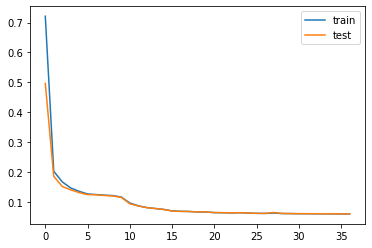

In [82]:
plt.plot(losses_train,label='train')
plt.plot(losses_test,label='test')
plt.legend()
plt.show()

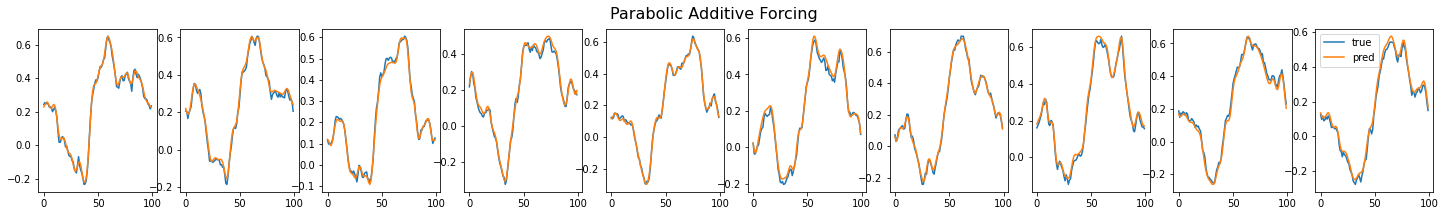

In [83]:
k = 5
T_= 10

# u0 = u0_train[k][None,...].to(device)
# u = u_train[k][None,...].to(device) 
# xi = xi_train[k][None,...].to(device)
u0 = u0_test[k][None,...].to(device)
u = u_test[k][None,...].to(device) 
xi = xi_test[k][None,...].to(device)

u_pred = model(u0,xi)

fig, ax = plt.subplots(1,T_,figsize=(25,3))
# fig = plt.figure(figsize=(10,3))
plt.suptitle('Parabolic Additive Forcing', fontsize=16)

for i in range(T_):
  ax[i].plot(u[0,...,39+i].detach().cpu().numpy(),label='true')
  ax[i].plot(u_pred[0,0,...,39+i].detach().cpu().numpy(),label='pred')
 # ax[0][i+1].set_title(f'time step {i+1}')

plt.legend()
# plt.tight_layout()
plt.show()

# FNO (Space-time FFT)

In [108]:
reload(fourier_space1D_time)
import fourier_space1D_time
from fourier_space1D_time import FNO_space1D_time

In [121]:
xi = torch.from_numpy(W.astype(np.float32)).permute(0,2,1)
data = torch.from_numpy(Soln_mult.astype(np.float32)).permute(0,2,1)

In [122]:
ntrain = 1800
ntest = 200

S = 100

batch_size = 20
epochs = 5000
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5
step = 1
T = 50
sub_t = 1

u_train = data[:ntrain,:-1,1:T:sub_t]
xi_train = xi[:ntrain, :-1,1:T:sub_t].reshape(ntrain,S,1,T-1).repeat([1,1,T-1,1])
# xi_train = torch.diff(xi[:ntrain, :-1,:T:sub_t],dim=-1)

u_test = data[-ntest:,:-1,1:T:sub_t]
xi_test = xi[-ntest:, :-1,1:T:sub_t].reshape(ntest,S,1,T-1).repeat([1,1,T-1,1])
# xi_test = torch.diff(xi[-ntest:, :-1,:T:sub_t],dim=-1)[:,None,...]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xi_train, u_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xi_test, u_test), batch_size=batch_size, shuffle=False)

In [125]:
model = FNO_space1D_time(modes1=32, modes2=16, width=16, T=T-1).cuda()

print(count_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

265585


In [126]:
myloss = LpLoss(size_average=False)
losses_train = []
losses_test = []
for ep in range(epochs):

    model.train()
    
    train_loss = 0.
    for xi_, u_ in train_loader:

        loss = 0.

        xi_ = xi_.to(device)
        u_ = u_.to(device)

        u_pred = model(xi_)

        loss = myloss(u_pred.reshape(batch_size, -1), u_.reshape(batch_size, -1))

        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
    test_loss = 0.
    with torch.no_grad():
        for xi_, u_ in test_loader:
            
            loss = 0.
            
            xi_ = xi_.to(device)
            u_ = u_.to(device)

            u_pred = model(xi_)

            loss = myloss(u_pred.reshape(batch_size, -1), u_.reshape(batch_size, -1))

            test_loss += loss.item()

    scheduler.step()
    if ep%20==0:
      losses_train.append(train_loss/ntrain)
      losses_test.append(test_loss/ntest)
      print('Epoch {:04d} | Total Train Loss {:.6f} | Total Test Loss {:.6f}'.format(ep, train_loss / ntrain, test_loss / ntest))

Epoch 0000 | Total Train Loss 0.732520 | Total Test Loss 0.630837
Epoch 0020 | Total Train Loss 0.363695 | Total Test Loss 0.357984
Epoch 0040 | Total Train Loss 0.336226 | Total Test Loss 0.331629
Epoch 0060 | Total Train Loss 0.316099 | Total Test Loss 0.312860
Epoch 0080 | Total Train Loss 0.304738 | Total Test Loss 0.300898
Epoch 0100 | Total Train Loss 0.298426 | Total Test Loss 0.295343
Epoch 0120 | Total Train Loss 0.292151 | Total Test Loss 0.290473
Epoch 0140 | Total Train Loss 0.288139 | Total Test Loss 0.285489
Epoch 0160 | Total Train Loss 0.283219 | Total Test Loss 0.281106
Epoch 0180 | Total Train Loss 0.279441 | Total Test Loss 0.276596
Epoch 0200 | Total Train Loss 0.279911 | Total Test Loss 0.277434
Epoch 0220 | Total Train Loss 0.276137 | Total Test Loss 0.274804
Epoch 0240 | Total Train Loss 0.274343 | Total Test Loss 0.272595
Epoch 0260 | Total Train Loss 0.272496 | Total Test Loss 0.270147
Epoch 0280 | Total Train Loss 0.272013 | Total Test Loss 0.269613
Epoch 0300

KeyboardInterrupt: ignored

#NCDE

In [20]:
from NCDE import NeuralCDE

In [21]:
xi = torch.from_numpy(W.astype(np.float32)).permute(0,2,1)
data = torch.from_numpy(Soln_mult.astype(np.float32)).permute(0,2,1)

In [22]:
ntrain = 800
ntest = 200

S = 100

batch_size = 20
epochs = 500
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5
step = 1
T = 50
sub_t = 1

u0_train = data[:ntrain,:-1,0]
u_train = data[:ntrain,:-1,1:T:sub_t].permute(0,2,1)
xi_train = xi[:ntrain, :-1,1:T:sub_t].permute(0,2,1)
# xi_train = torch.diff(xi[:ntrain, :-1,:T:sub_t],dim=-1)
t = torch.linspace(0., 1, T)[None,1:,None].repeat(ntrain,1,1)
xi_train = torch.cat([t,xi_train],dim=2)

u0_test = data[-ntest:,:-1,0]
u_test = data[-ntest:,:-1,1:T:sub_t].permute(0,2,1)
xi_test = xi[-ntest:, :-1,1:T:sub_t].permute(0,2,1)
# xi_test = torch.diff(xi[-ntest:, :-1,:T:sub_t],dim=-1)[:,None,...]
t = torch.linspace(0., 1, T)[None,1:,None].repeat(ntest,1,1)
xi_test = torch.cat([t,xi_test],dim=2)

# interpolation
xi_train = torchcde.linear_interpolation_coeffs(xi_train)
xi_test = torchcde.linear_interpolation_coeffs(xi_test)
# xi_train = torchcde.hermite_cubic_coefficients_with_backward_differences(xi_train)
# xi_test = torchcde.hermite_cubic_coefficients_with_backward_differences(xi_test)

In [23]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u0_train, xi_train, u_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(u0_test, xi_test, u_test), batch_size=batch_size, shuffle=False)

In [24]:
model = NeuralCDE(input_channels=S+1, hidden_channels=2, output_channels=S, interpolation='linear').cuda()
print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

26944


In [25]:
myloss = LpLoss(size_average=False)
losses_train = []
losses_test = []
for ep in range(epochs):

    model.train()
    
    train_loss = 0.
    for u0_, xi_, u_ in train_loader:

        loss = 0.

        u0_ = u0_.to(device)
        xi_ = xi_.to(device)
        u_ = u_.to(device)

        u_pred = model(u0_, xi_)

        loss = myloss(u_pred.reshape(batch_size, -1), u_.reshape(batch_size, -1))

        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
 
    test_loss = 0.
    with torch.no_grad():
        for u0_, xi_, u_ in test_loader:
            
            loss = 0.
            
            u0_ = u0_.to(device)
            xi_ = xi_.to(device)
            u_ = u_.to(device)

            u_pred = model(u0_, xi_)

            loss = myloss(u_pred.reshape(batch_size, -1), u_.reshape(batch_size, -1))

            test_loss += loss.item()

    scheduler.step()
    if ep%20==0:
      losses_train.append(train_loss/ntrain)
      losses_test.append(test_loss/ntest)
      print('Epoch {:04d} | Total Train Loss {:.6f} | Total Test Loss {:.6f}'.format(ep, train_loss / ntrain, test_loss / ntest))

Epoch 0000 | Total Train Loss 14.248213 | Total Test Loss 12.798864


KeyboardInterrupt: ignored